# Dimensionality Reduction

In [1]:
# For Deepnote to be able to use the custom libraries in the parent ../lib folder
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
from lib.read_data import read_and_join_output_file
from lib.impute import create_transformation_pipelines, train_test_group_time_split
from lib.viz import draw_missing_data_chart, draw_corr_heatmap, draw_components_variance_chart, biplot, draw_feature_importance
from sklearn.decomposition import PCA
from sklearn import set_config

In [3]:
RANDOM_SEED = 42
# Load the data from the ETL output files
X = read_and_join_output_file()
# Split the data into a training and a test set
X_train, X_test = train_test_group_time_split(X, index=["TOWNSHIP_RANGE", "YEAR"], group="TOWNSHIP_RANGE", random_seed=RANDOM_SEED)
# Create, fit and apply the data imputation pipeline to the training and test sets
impute_pipeline, columns = create_transformation_pipelines(X_train)
X_train_impute = impute_pipeline.fit_transform(X_train)
X_test_impute = impute_pipeline.transform(X_test)
# Combine the imputed training and test sets for the dimensionality reduction
X_train_impute_df = pd.DataFrame(X_train_impute, index=X_train.index, columns=columns)
X_test_impute_df = pd.DataFrame(X_test_impute, index=X_test.index, columns=columns)
X_impute_df = pd.concat([X_train_impute_df, X_test_impute_df], axis=0)
X_impute_df.sort_index(level=["TOWNSHIP_RANGE", "YEAR"], inplace=True)

## Feature Correlation

In [4]:
draw_corr_heatmap(X_impute_df)

alt.Chart(...)

### Feature Correlation Observations

Features describing the dimensions and capacity of a well show some strong level of correlation which is expectd:
* `TOTALCOMPLETEDDEPTH_AVG` and `STATICWATERLEVEL_AVG` are both highly correlated with `TOPOFPERFORATEDINTERVAL_AVG` and `BOTTOMOFPERFORATEDINTERVAL_AVG`.
* `TOTALCOMPLETEDDEPTH_AVG` and `STATICWATERLEVEL_AVG` are also both correlated with each other.

We also see some level of correlation between the different type of forest vegetation. For example `VEGETATION_CANYON_LIVE_OAK`, `VEGETATION_HARD` and `VEGETATION_KNOBCONE_PINE` show correlation values between 0.46 and 0.6. This might be explained by the fact that some type of vegetation tend to live together.

We observe some few other correlations between
* some type of crops (e.g. 0.57 between `CROP_D16` *plums, prunes or apricots* and `CROP_D5` which is ** some type of crops (e.g. 0.57 between `CROP_D16` *plums, prunes or apricots* and `CROP_D5` which is *peaches/nectarines*
* or between some crops and soils (e.g. 0.61 between `CROP_T31` *potatoes and sweet potatoes* and `SOIL_ENTISOLS_A` *Little, if any horizon development* soil of hydrographic group *A* corresponding to coarse texture soils with high saturated hydraulic conductivity. This correlation also makes sense since potatoes tend to not grow well in soils retaining too much water.

We also see that none of the two features we are interested in predicting (`GSE_GWE`, `SHORTAGE_COUNT`) show any strong correlation with any feature.

## Dimensionality Reduction
If we analyzed the correlation above on the entire dataset, we perform dimensionality reduction only on the training set to avoid data leackage.
### PCA

In [5]:
## Set the index of the dataframe to be a combination of TOWNSHIP_RANGE and YEAR so that it does not
## interfere with the PCA
pca = PCA(n_components = 3, random_state=RANDOM_SEED).fit(X_train_impute_df)

# How many features will it take to explain 95% of the variance
pca = PCA(random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_train_impute_df)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X_train_impute_df.shape[1] - n_over_95 + 1
print(f"Number features: {n_to_reach_95}\tTotal Variance Explained: {total_explained_variance[n_to_reach_95-1]}")

Number features: 33	Total Variance Explained: 0.9503103098476


In [7]:
draw_components_variance_chart(pca)

alt.Chart(...)

In [8]:
crops_features = [c for c in X_train_impute_df.columns if c.startswith("CROP_")]
crops_features_idx = [X_train_impute_df.columns.get_loc(c) for c in crops_features]
soils_features = [c for c in X_train_impute_df.columns if c.startswith("SOIL_")]
soils_features_idx = [X_train_impute_df.columns.get_loc(c) for c in soils_features]
vegetation_features = [c for c in X_train_impute_df.columns if c.startswith("VEGETATION_")]
vegetation_features_idx = [X_train_impute_df.columns.get_loc(c) for c in vegetation_features]
other_features = list(set(X_train_impute_df.columns) - set(crops_features) - set(soils_features) - set(vegetation_features))
other_features_idx = [X_train_impute_df.columns.get_loc(c) for c in other_features]

<module 'matplotlib.pyplot' from 'D:\\anaconda3\\envs\\milestone2\\lib\\site-packages\\matplotlib\\pyplot.py'>

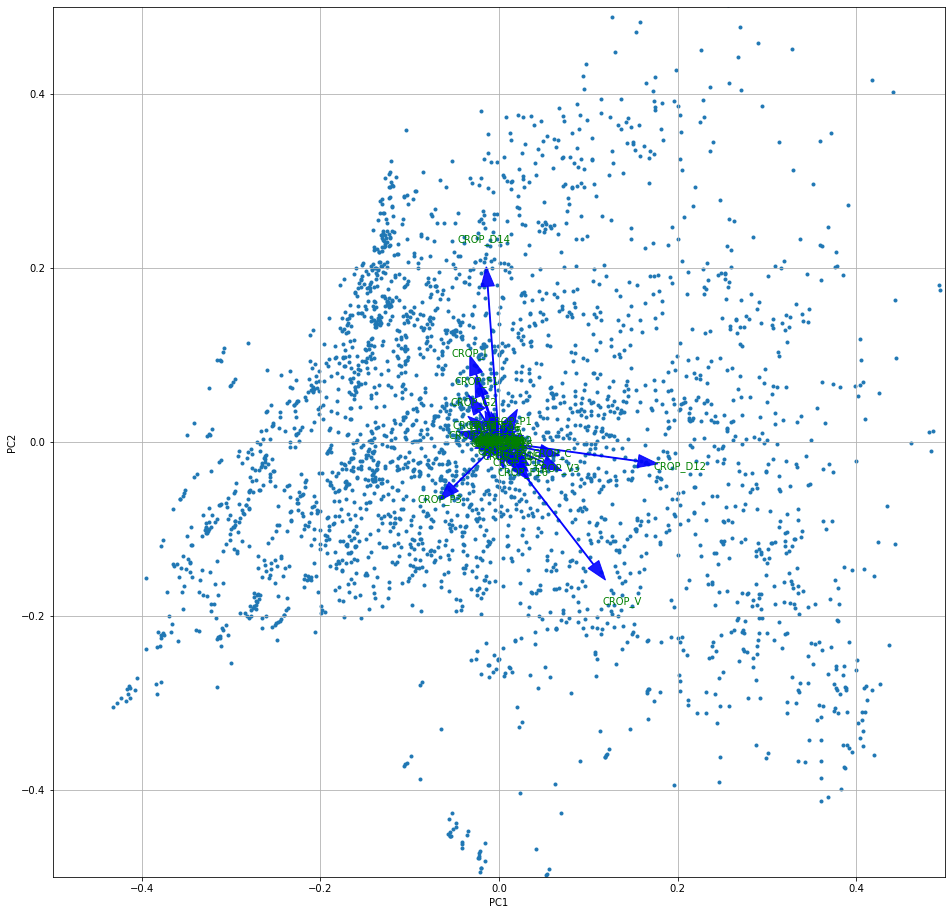

In [9]:
biplot(X_pca, np.transpose(pca.components_[0:2, crops_features_idx]),
       len(crops_features), 1, 2, labels=crops_features)

<module 'matplotlib.pyplot' from 'D:\\anaconda3\\envs\\milestone2\\lib\\site-packages\\matplotlib\\pyplot.py'>

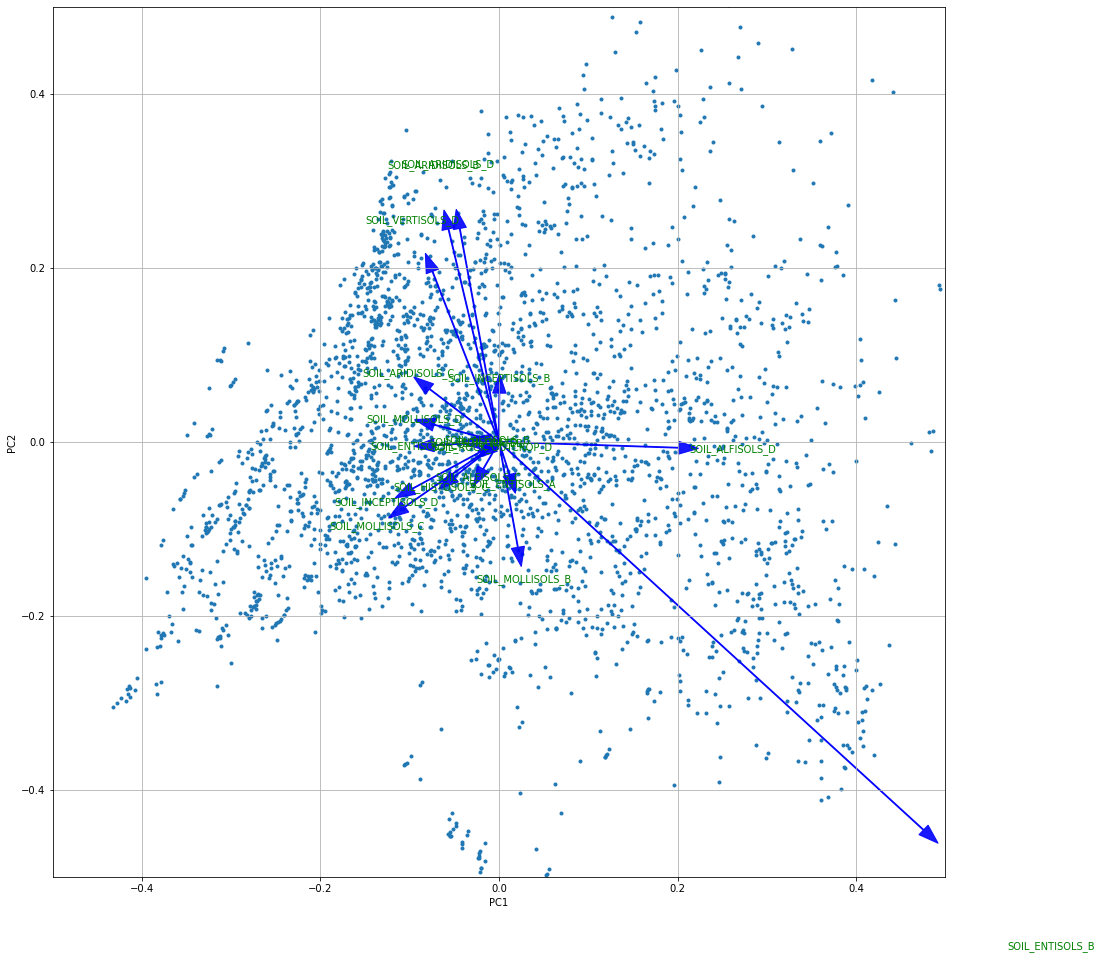

In [10]:
biplot(X_pca, np.transpose(pca.components_[0:2, soils_features_idx]),
       len(soils_features), 1, 2, labels=soils_features)

<module 'matplotlib.pyplot' from 'D:\\anaconda3\\envs\\milestone2\\lib\\site-packages\\matplotlib\\pyplot.py'>

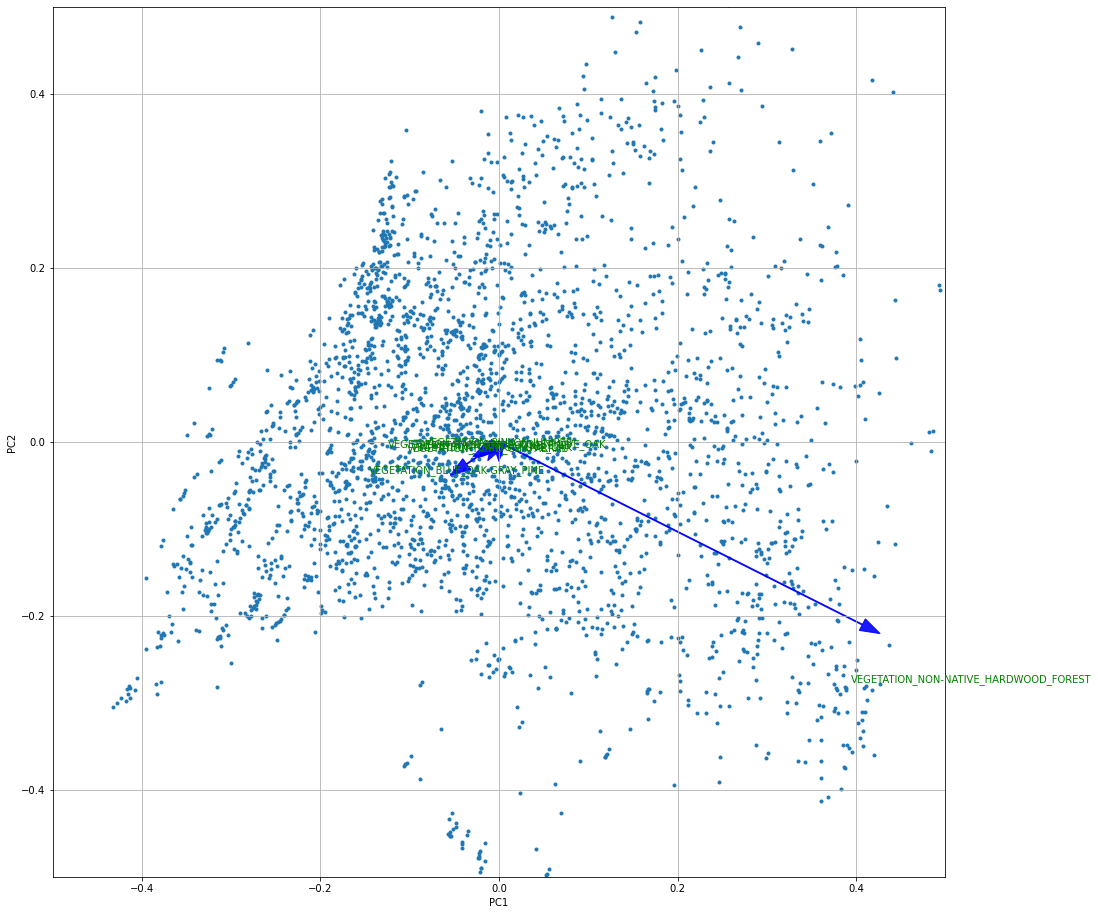

In [11]:
biplot(X_pca, np.transpose(pca.components_[0:2, vegetation_features_idx]),
       len(vegetation_features), 1, 2, labels=vegetation_features)

<module 'matplotlib.pyplot' from 'D:\\anaconda3\\envs\\milestone2\\lib\\site-packages\\matplotlib\\pyplot.py'>

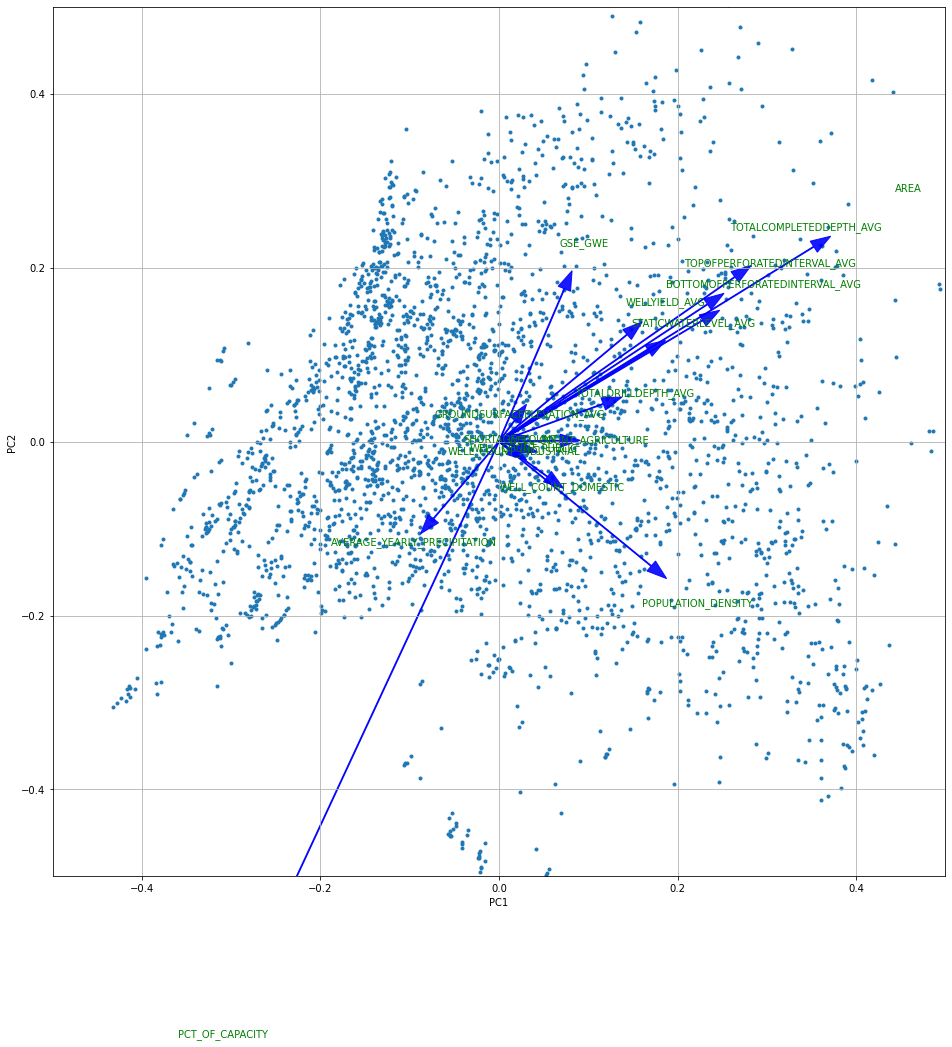

In [12]:
biplot(X_pca, np.transpose(pca.components_[0:2, other_features_idx]),
       len(other_features), 1, 2, labels=other_features)